**브런치 사용자를 위한 글 및 작가 추천 전처리 및 EDA**

*Table of Contents*
1. 필요모듈 import & file read
2. 데이터 전처리
3. EDA
4. Train Data
5. Data Module
---

# 필요 모듈 import & file read
- 파일명/ 컬럼
    - metadata : 2018년 10월 1일부터 2019년 3월 14일까지 독자들이 본 글에 대한 정보
        - 매거진 id [magazine_id]  
        - 등록 시간 [reg_ts]
        - 작가 id [user_id] → [author_id]
        - 아티클 id [article_id] → [article_number]
        - 글번호 /작가정보 [id] → [article_id]
        - 제목 [title]
        - 부제 [sub_title]
        - url [display_url]
        - 키워드 리스트 (작가부여) [keyword_list]
    - users : 사용자 정보
        - 독자 id : 비식별화된 독자 아이디 [id] → [readers_id]
        - 구독중 작가 리스트 [following_list]
        - 키워드 리스트 : 독자가 검색한 키워드 [keyword_list] → [search_keyword_list]
    - read : 읽은 글에 대한 정보
        - 독자 id [id] → [readers_id]
        - 아티클 id [article_id]
    - magazine : 
        - 매거진 id [id] → [magazine_id]
        - 매거진 태그 리스트 [magazine_tag_list]

In [21]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re
import warnings
warnings.filterwarnings('ignore')

In [7]:
from numpy.polynomial.polynomial import polyfit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
sns.set_style("whitegrid")

font_location = "C:\Windows\Fonts/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc("font", family=font_name)
mpl.rcParams["font.family"]
mpl.matplotlib_fname()
plt.rcParams["figure.figsize"] = (20, 10)

# 1. Data Read & Data Preprocessing

## 1) Metadata.json
- 컬럼명 변경
    - user_id → author_id
    - id → article_id
    - article_id → article_number

In [6]:
metadata = pd.read_json('metadata.json', lines=True)

In [2]:
metadata.rename(columns={"user_id": "author_id",
                         "article_id": "article_number", "id": "article_id"}, inplace=True)

In [44]:
metadata.head()

author_id       keyword_list         reg_ts  article_number  \
0        @bookdb     [여행, 호주, 국립공원]  1474944427000             782   
1     @kohwang56    [목련꽃, 아지랑이, 동행]  1463092749000              81   
2   @hannahajink                 []  1447997287000               4   
3  @bryceandjuli       [감정, 마음, 위로]  1491055161000              88   
4   @mijeongpark  [유럽여행, 더블린, 아일랜드]  1523292942000              34   

         article_id        reg_datetime  
0       @bookdb_782 2016-09-27 11:47:07  
1     @kohwang56_81 2016-05-13 07:39:09  
2    @hannahajink_4 2015-11-20 14:28:07  
3  @bryceandjuli_88 2017-04-01 22:59:21  
4   @mijeongpark_34 2018-04-10 01:55:42

In [7]:
metadata.shape

(643104, 9)

In [8]:
# metadata의 결측치 값 확인
metadata.isnull().values.any()

False

In [9]:
metadata.to_csv("metadata_final.csv", index=False)

## 2) Magazine.json
- 컬럼명 변경
    - id → magazine_id

In [65]:
magazine = pd.read_json('magazine.json', lines=True)

In [66]:
magazine.rename(columns={"id": "magazine_id"}, inplace=True)

In [12]:
magazine.head()

magazine_tag_list  magazine_id
0  [브런치북, 육아일기, 대화법, 들려주고픈이야기]        38842
1                  [tea, food]        11540
2                       [food]        11541
3            [브런치북, 일상, 시, 사람]        11546
4           [감성에세이, 노래, 음악에세이]        11544

In [13]:
magazine.to_csv("magazine_final.csv", index=False)

## 3) Users.json
- 컬럼명 변경
    - id → readers_id
    - keyword_list → search_keyword_list

In [42]:
users = pd.read_json('users.json', lines=True)

In [43]:
users.rename(columns={"id": "readers_id", "keyword_list": "search_keyword_list"}, inplace=True)

In [107]:
users.head()

search_keyword_list                                     following_list  \
0                  []                               [@perytail, @brunch]   
1                  []  [@holidaymemories, @wadiz, @sciforus, @dailydu...   
2                  []  [@commerceguy, @sunsutu, @kakao-it, @joohoonja...   
3                  []  [@amberjeon48, @forsy20, @nemotokki, @hawann, ...   
4                  []  [@dwcha7342, @iammento, @kakao-it, @dkam, @ant...   

                          readers_id  
0  #901985d8bc4c481805c4a4f911814c4a  
1  #1fd89e9dcfa64b45020d9eaca54e0eed  
2  #1d94baaea71a831e1f33e1c6bd126ed5  
3  #04641c01892b12dc018b1410e4928c0d  
4  #65bcaff862aadff877e461f54187ab62

In [17]:
users.to_csv("users_final.csv", index=False)

## 4) Read Files
- 컬럼명 변경
    - id → readers_id

In [22]:
read_file_lst = glob.glob('C:\\Users\\Jisoo\\Desktop\\2020_Machine_Learning_Project\\read\\*')

In [23]:
read_df_lst = []
for file in read_file_lst:
    file_name = os.path.basename(file)
    file_df = pd.read_csv(file, header=None, names=["raw"])
    file_df["dt"] = file_name[:8]
    file_df["hr"] = file_name[8:10]
    file_df["readers_id"] = file_df["raw"].str.split(" ").str[0]
    file_df["article_id"] = file_df["raw"].str.split(" ").str[1:].str.join(" ").str.strip()
    read_df_lst.append(file_df)

In [24]:
read_df = pd.concat(read_df_lst)

In [13]:
read_df.head()

raw        dt  hr  \
0     #e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91   20181001  00   
1  #0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...  20181001  00   
2  #b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...  20181001  00   
3  #b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...  20181001  00   
4  #072f742eda9359cdac03ad080193c11d @doyeonsunim...  20181001  00   

                          readers_id  \
0  #e208be4ffea19b1ceb5cea2e3c4dc32c   
1  #0a3d493f3b2318be80f391eaa00bfd1c   
2  #b90d3ee7ed0d7d827aae168e159749f1   
3  #b8b9d09fe2961fd62edc94912bf75a90   
4  #072f742eda9359cdac03ad080193c11d   

                                          article_id  
0                                        @kty0613_91  
1  @miamiyoung_31 @banksalad_49 @rlfrjsdn_95 @rea...  
2                               @joeunha_4 @yoonvi_3  
3  @hyejinchoi_122 @hyejinchoi_86 @hyejinchoi_42 ...  
4  @doyeonsunim_240 @k52524_297 @bule13_33 @kwong...

##### 데이터 정리
- author_article_id의 list 형태로 된 values 나누기

In [25]:
read_count = read_df["article_id"].str.split(" ").map(len)

In [26]:
read = pd.DataFrame({"dt": np.repeat(read_df["dt"], read_count),
                     "hr": np.repeat(read_df["hr"], read_count),
                     "readers_id": np.repeat(read_df["readers_id"], read_count),
                     "article_id": list(chain.from_iterable(read_df["article_id"].str.split(" ")))})

In [17]:
read.head()

dt  hr                         readers_id      article_id
0  20181001  00  #e208be4ffea19b1ceb5cea2e3c4dc32c     @kty0613_91
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c  @miamiyoung_31
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c   @banksalad_49
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c    @rlfrjsdn_95
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c  @readme999_140

In [25]:
print("전체 데이터 건수:", read.shape)
print("중복 소비를 제외한 데이터 건수:",
      read[['readers_id', 'article_id']].drop_duplicates().shape)
print("Unique 독자 수:", len(read['readers_id'].unique()))
print("소비된 Unique 글 수:", len(read['article_id'].unique()))

전체 데이터 건수: (22110706, 4)
중복 소비를 제외한 데이터 건수: (12597878, 2)
Unique 독자 수: 306222
소비된 Unique 글 수: 505841


- author_article_id가 비식별화된 경우가 92767건

In [28]:
read.to_csv("read_final.csv", index=False)

# 2. EDA & Data Preprocessing

## 1) 글 수 

### a. metadata 전처리

In [29]:
atc = metadata.copy()

In [30]:
atc["reg_datetime"] = atc["reg_ts"].apply(lambda x: datetime.fromtimestamp(x/1000.0))
atc["reg_dt"] = atc["reg_datetime"].dt.date
atc["type"] = atc["magazine_id"].apply(lambda x: "개인" if x == 0.0 else "매거진")

In [31]:
atc.head(3)

magazine_id     author_id                      title     keyword_list  \
0         8982       @bookdb  사진으로 옮기기에도 아까운, 리치필드 국립공원   [여행, 호주, 국립공원]   
1        12081    @kohwang56                  [시] 서러운 봄  [목련꽃, 아지랑이, 동행]   
2            0  @hannahajink                     무엇을 위해               []   

                           display_url             sub_title         reg_ts  \
0     https://brunch.co.kr/@bookdb/782  세상 어디에도 없는 호주 Top 10  1474944427000   
1   https://brunch.co.kr/@kohwang56/81                        1463092749000   
2  https://brunch.co.kr/@hannahajink/4                무엇 때문에  1447997287000   

   article_number      article_id        reg_datetime      reg_dt type  
0             782     @bookdb_782 2016-09-27 11:47:07  2016-09-27  매거진  
1              81   @kohwang56_81 2016-05-13 07:39:09  2016-05-13  매거진  
2               4  @hannahajink_4 2015-11-20 14:28:07  2015-11-20   개인

In [32]:
atc.isnull().values.any()

False

### b. 등록일자별 글 수

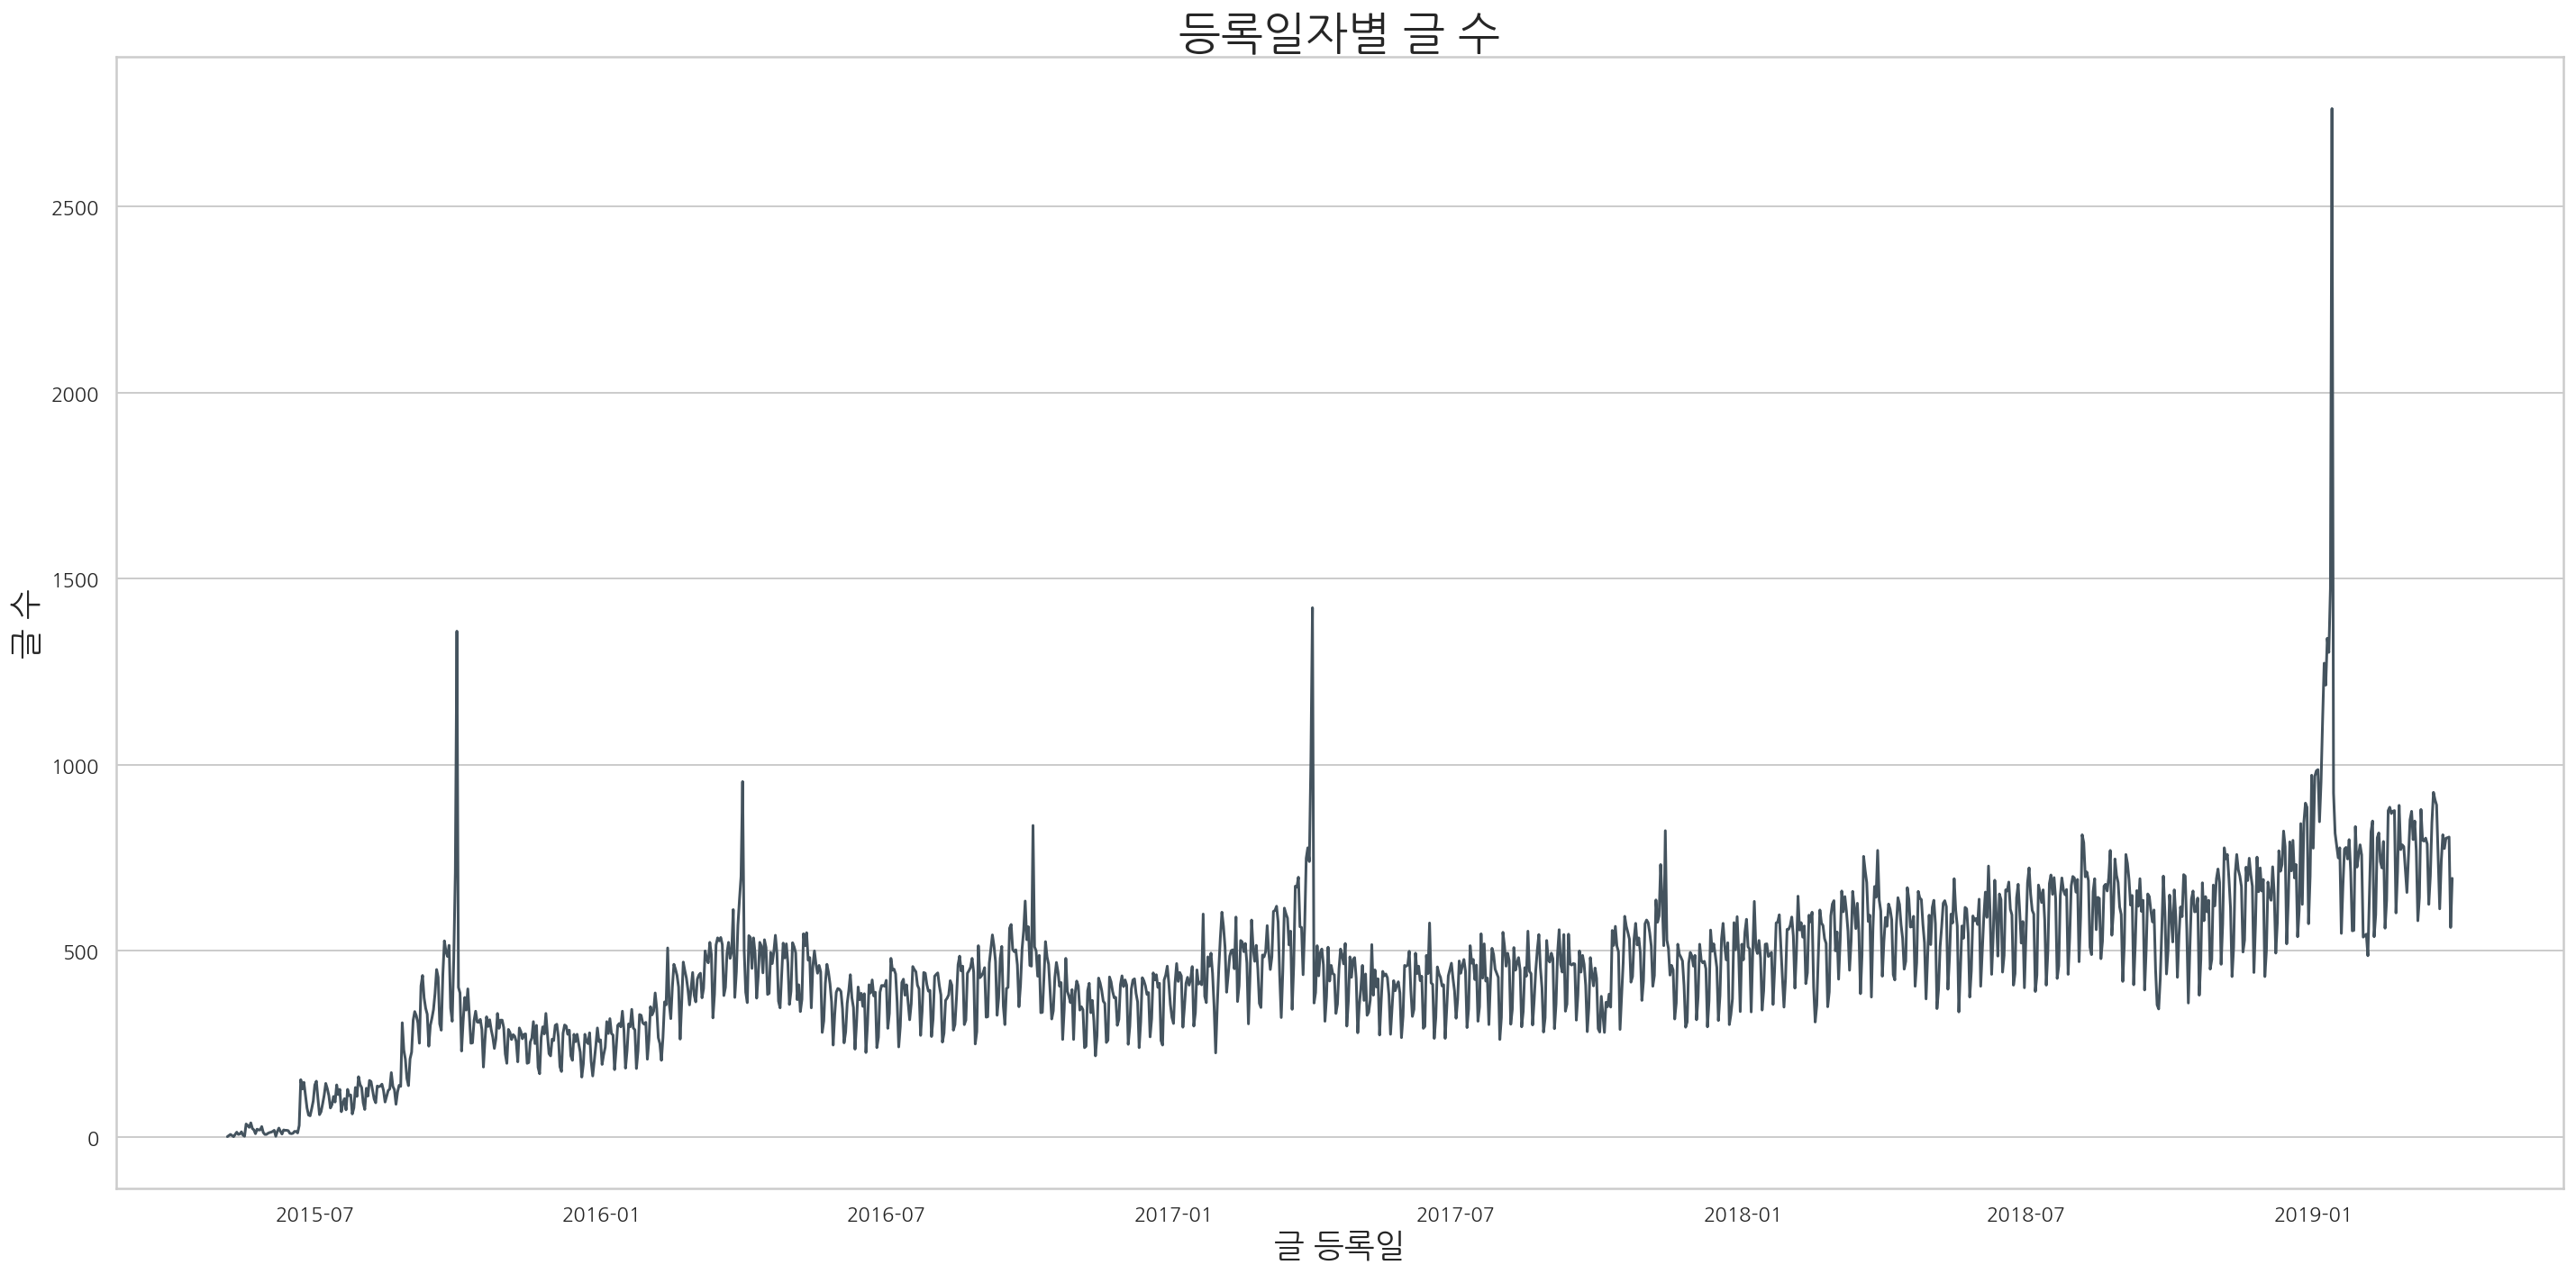

In [33]:
sns.lineplot(data=atc.groupby("reg_dt", as_index=False)["article_id"].count()[
             1:], x="reg_dt", y="article_id", color="#44535e")
plt.title("등록일자별 글 수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 수", fontsize=18)
plt.grid(axis="x")

plt.savefig("Brunch_등록일자별_글_수.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 일자가 최신일수록 등록된 글의 수가 많음

## 2) 글 소비

### a. 글별 소비수 통계
- author_article_id 가 없는 글 제외하고 글의 소비를 분석

In [34]:
atc_read_cnt = read[read.article_id != ""].groupby(
    "article_id", as_index=False)["readers_id"].count()
atc_read_cnt.rename(columns={"readers_id": "read_cnt"}, inplace=True)

In [35]:
atc_read_cnt.isnull().values.any()

False

In [36]:
# 글별 소비수 통계
atc_read_cnt.describe()

read_cnt
count  505840.000000
mean       43.700988
std       302.292764
min         1.000000
25%         3.000000
50%         8.000000
75%        25.000000
max     97206.000000

In [37]:
atc_read_cnt[atc_read_cnt.read_cnt == 97206]

article_id  read_cnt
63061  @brunch_141     97206

- 글 한개당 글별 소비수의 최소는 1회이며 최대는 97206회(@brunch_141글) 소비를 함
- 글 한개당 글별 소비수의 평균은 43.7회

In [38]:
# metadata 결합 (article_id 가 없는 아이들 제외하고 결합됨.)
atc_read_cnt = pd.merge(atc_read_cnt, atc, how=left",
                        left_on="article_id", right_on="article_id")

In [39]:
atc_read_cnt.isnull().values.any()

True

atc_read_cnt(read 데이터)에는 비식별화된 author_article_id가 있음 <br>
하지만 metadata에는 article의 정보로 이루어졌기에 비식별화된 author_article_id는 없음 <br>
그래서 metadata와 act_read_cnt데이터를 merge한 act_read_cnt 데이터에서는 결측치가 존재한다

In [40]:
atc_read_cnt.tail()

article_id  read_cnt  magazine_id  author_id  \
505835    @zzzaam_6       114          0.0    @zzzaam   
505836    @zzzaam_7        42          0.0    @zzzaam   
505837    @zzzaam_8        80          0.0    @zzzaam   
505838    @zzzaam_9        43          0.0    @zzzaam   
505839  @zzzwhite_4         2          0.0  @zzzwhite   

                             title       keyword_list  \
505835     좋은 제품 UX 디자인을 위한 9가지 방법  [디자인, UX, design]   
505836              반복적 디자인에 대한 소고      [UX, 전략, 사용성]   
505837  인공지능과 미래의 디자인: 2025년의 디자이너    [인공지능, AI, 디자인]   
505838            디자인팀에 작가가 필요한 이유      [UX, 작가, 글쓰기]   
505839                    너는 희망이다.     [감성그림, 희망, 엄마]   

                             display_url  \
505835    https://brunch.co.kr/@zzzaam/6   
505836    https://brunch.co.kr/@zzzaam/7   
505837    https://brunch.co.kr/@zzzaam/8   
505838    https://brunch.co.kr/@zzzaam/9   
505839  https://brunch.co.kr/@zzzwhite/4   

                                       sub_title        reg_ts  \
505835                    Hacking Product Design  1.489403e+12   
505836                   Iteration is not design  1.490278e+12   
505837                              AI와 휴머니티의 간극  1.493136e+12   
505838  Writers + Designers = A match made in he  1.496501e+12   
505839                                     감성드로잉  1.467290e+12   

        article_number        reg_datetime      reg_dt type  
505835             6.0 2017-03-13 20:08:01  2017-03-13   개인  
505836             7.0 2017-03-23 23:00:17  2017-03-23   개인  
505837             8.0 2017-04-26 00:57:34  2017-04-26   개인  
505838             9.0 2017-06-03 23:39:22  2017-06-03   개인  
505839             4.0 2016-06-30 21:30:54  2016-06-30   개인

In [41]:
# metadata를 찾을 수 없는 소비 로그 제외 (비식별화 author_article_id 제거)
atc_read_cnt_nn = atc_read_cnt[atc_read_cnt["article_number"].notnull()]

In [42]:
# metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
atc_read_cnt_nn["read_cnt"].describe()

count    476147.000000
mean         43.904592
std         304.873256
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: read_cnt, dtype: float64

In [43]:
# 글별 소비수 90% 95% 기준 값
atc_read_cnt_nn["read_cnt"].quantile([0.90, 0.95])

0.90     72.0
0.95    142.0
Name: read_cnt, dtype: float64

In [44]:
# 소비수 기준 분류값
def quantile_read_class(x):
    if x >= 142:
        result = "5%"
    elif x >= 72:
        result = "10%"
    elif x >= 25:
        result = "25%"
    elif x >= 8:
        result = "50%"
    elif x >= 3:
        result = "75%"
    else:
        result = "100%"
    return result

In [45]:
atc_read_cnt_nn["class"] = atc_read_cnt_nn["read_cnt"].map(quantile_read_class)

In [46]:
atc_read_cnt_nn.head()

article_id  read_cnt  magazine_id  author_id  \
5417      @002_10         2          0.0       @002   
5418       @002_2         6          0.0       @002   
5419  @002jesus_1        10          0.0  @002jesus   
5420  @002paper_2         3          0.0  @002paper   
5421  @002paper_3         2          0.0  @002paper   

                             title     keyword_list  \
5417  '80% 안심계란' 포기하게 한 20% 살충제 계란    [계란, 살충제, 피해]   
5418            청년들은 '왜' 농촌으로 갔을까?  [귀촌, 농촌, 청년농업인]   
5419              우리는 왜 가난해야 하나요?     [후원, 기부, 비영리]   
5420              할수 있는 것과 하고 싶은 것   [제주, 서울생활, 서울]   
5421           긍정적으로 생각하며 주문을 걸기..  [바램, 일상에세이, 긍정]   

                           display_url                        sub_title  \
5417      https://brunch.co.kr/@002/10  정직한 농가에 대한 피해보상은 소비자 신뢰를 돌려주는 것   
5418       https://brunch.co.kr/@002/2  삶의 가치를 찾아 유랑하는 청년들의 'YOLO 라이프'    
5419  https://brunch.co.kr/@002jesus/1                비영리를 바라보는 편견들 (1)   
5420  https://brunch.co.kr/@002paper/2                      현실과 꿈의 거리..   
5421  https://brunch.co.kr/@002paper/3                  된다. 된다. 될거다....   

            reg_ts  article_number        reg_datetime      reg_dt type class  
5417  1.504448e+12            10.0 2017-09-03 23:12:35  2017-09-03   개인  100%  
5418  1.501030e+12             2.0 2017-07-26 09:46:45  2017-07-26   개인   75%  
5419  1.549456e+12             1.0 2019-02-06 21:18:49  2019-02-06   개인   50%  
5420  1.470905e+12             2.0 2016-08-11 17:49:42  2016-08-11   개인   75%  
5421  1.470913e+12             3.0 2016-08-11 19:58:52  2016-08-11   개인  100%

### b. 등록일자별 글 소비수

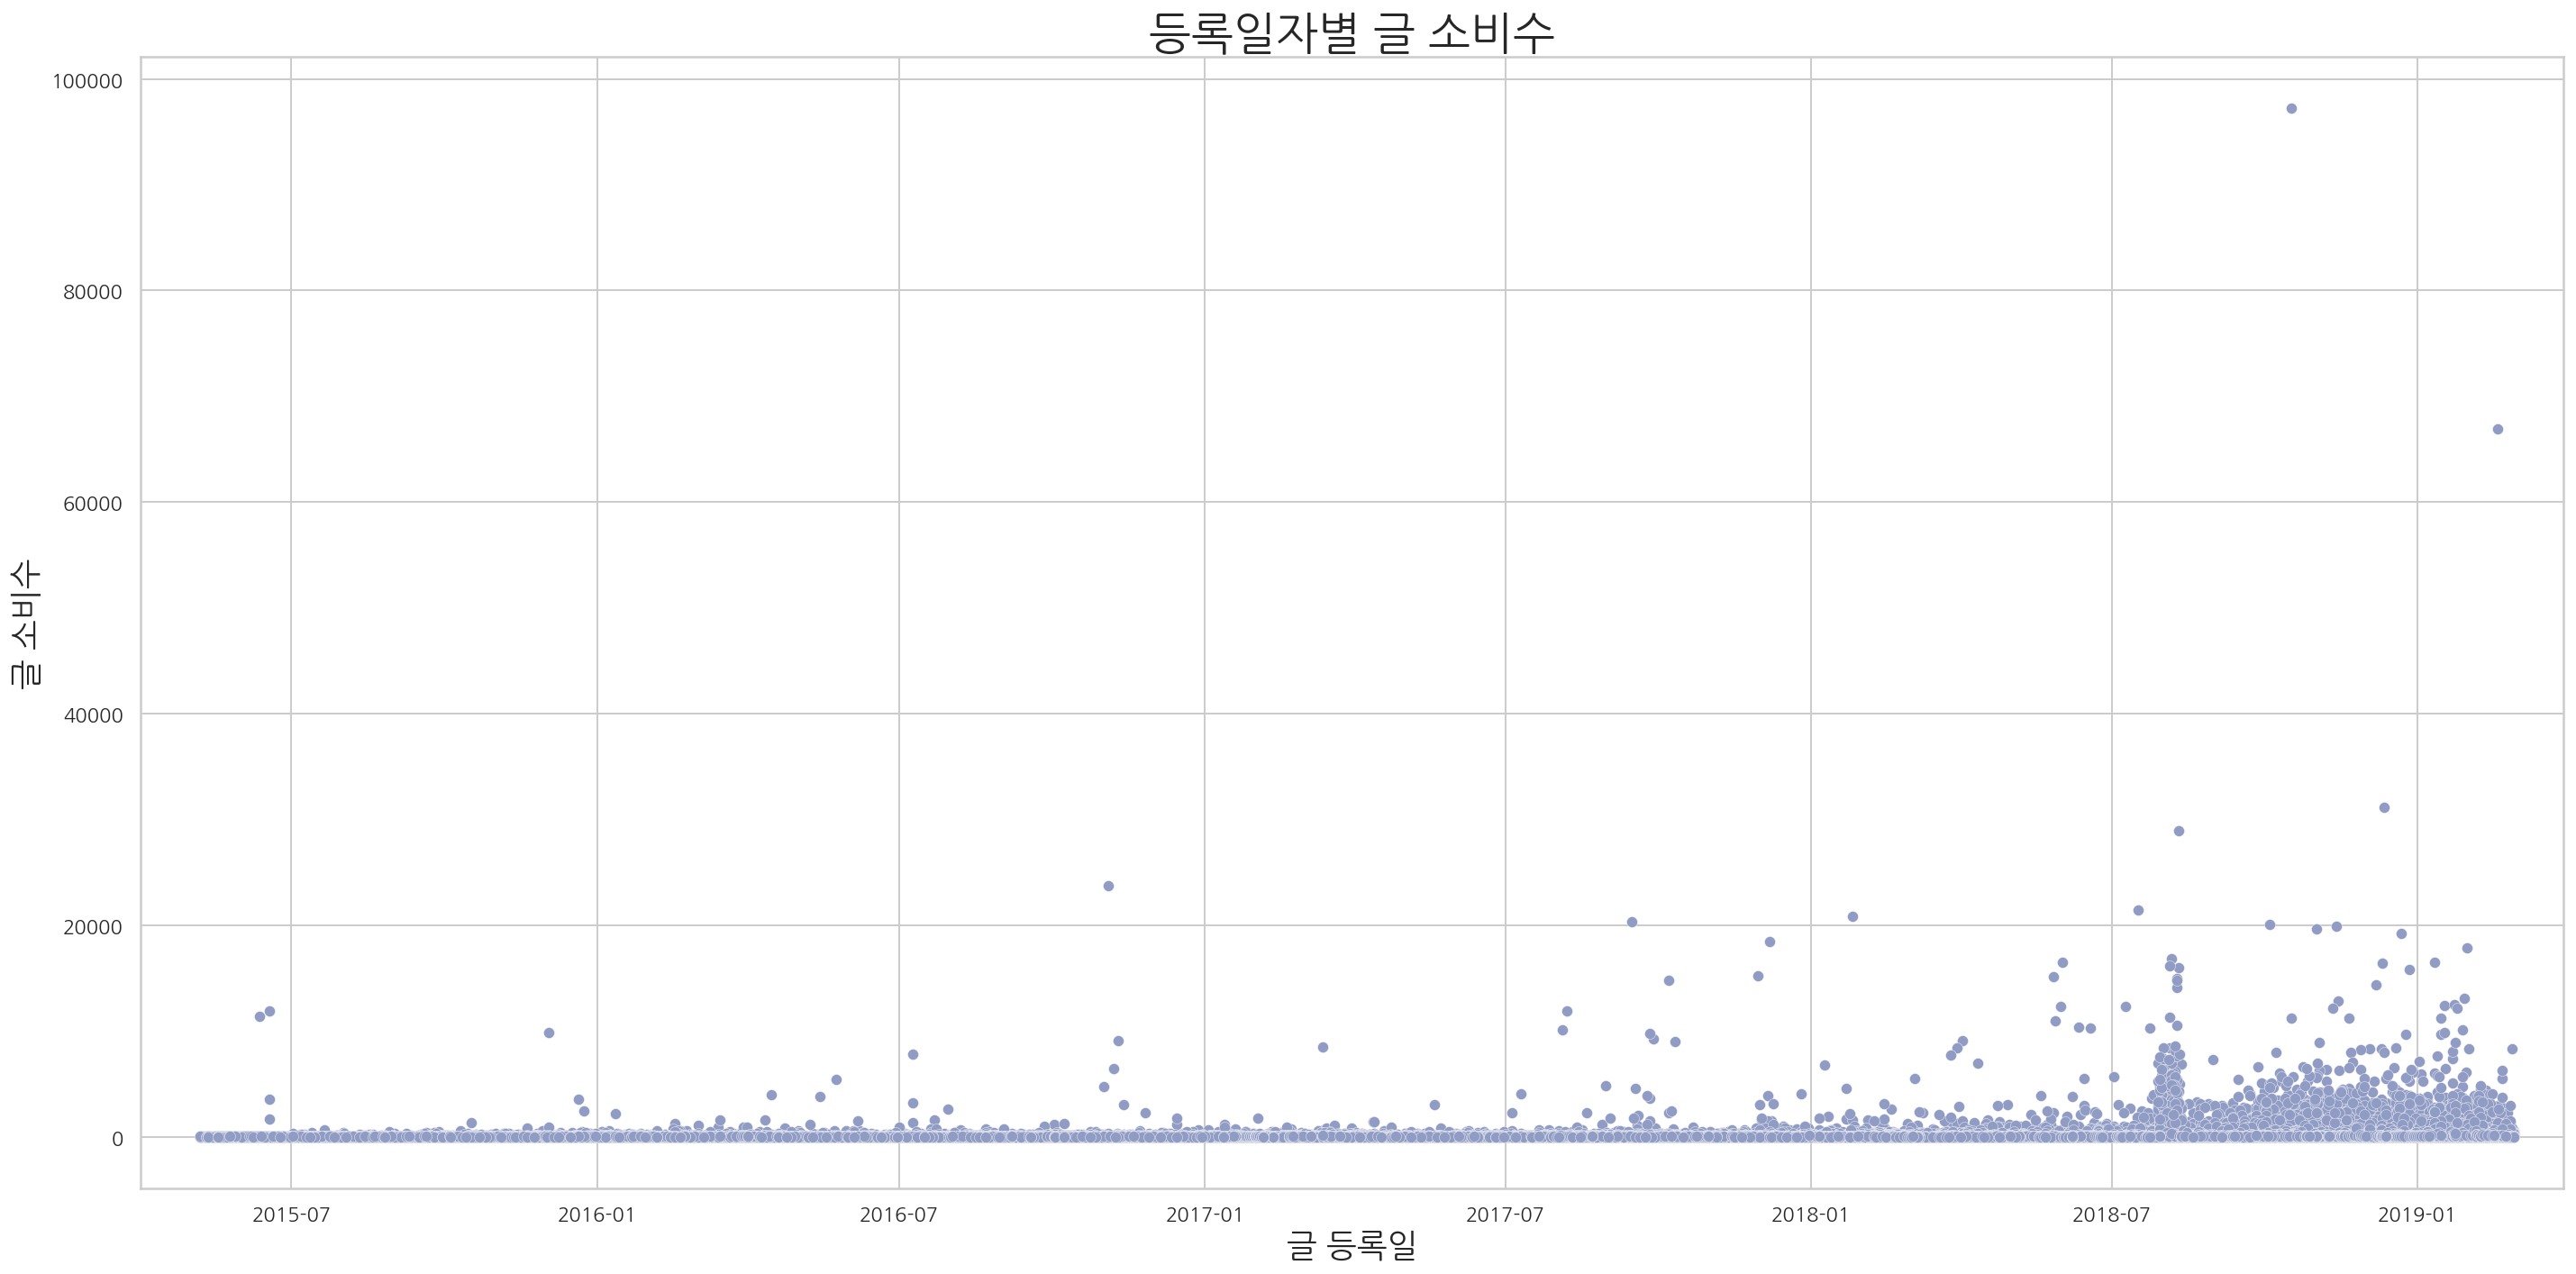

In [47]:
plt.scatter(x=atc_read_cnt_nn["reg_dt"], y=atc_read_cnt_nn["read_cnt"],
            c="#909cc4", edgecolors="w", linewidth=0.2)
plt.xlim(datetime.date(datetime(2015, 4, 1)),
         datetime.date(datetime(2019, 3, 30)))
plt.title("등록일자별 글 소비수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 소비수", fontsize=18)

plt.savefig("Brunch_등록일자별_글_소비수.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 두 개의 아티클이 글 소비수가 매우 높음 
- 그래프를 자세히 보기 위해 두 개의 아티클을 제외하고 다시 그려보자

In [48]:
atc_read_cnt_nn.sort_values(by="read_cnt", ascending=False).head(2)

article_id  read_cnt  magazine_id author_id  \
63061  @brunch_141     97206          0.0   @brunch   
63070  @brunch_151     66903          0.0   @brunch   

                            title                keyword_list  \
63061  브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.  [브런치X빨강머리앤, 빨강머리앤, 출판, 작가]   
63070  브런치 무비 패스, 영화의 진한 여운을 나누세요         [브런치, 시사회, 브런치무비패스]   

                            display_url           sub_title        reg_ts  \
63061  https://brunch.co.kr/@brunch/141    글·그림 작가 파트너 프로젝트  1.539742e+12   
63070  https://brunch.co.kr/@brunch/151  브런치 무비 패스 5기 작가 모집  1.550466e+12   

       article_number        reg_datetime      reg_dt type class  
63061           141.0 2018-10-17 11:11:22  2018-10-17   개인    5%  
63070           151.0 2019-02-18 14:00:34  2019-02-18   개인    5%

In [49]:
atc_read_cnt_nn_2 = atc_read_cnt_nn.sort_values(
    by="read_cnt", ascending=False)[2:]

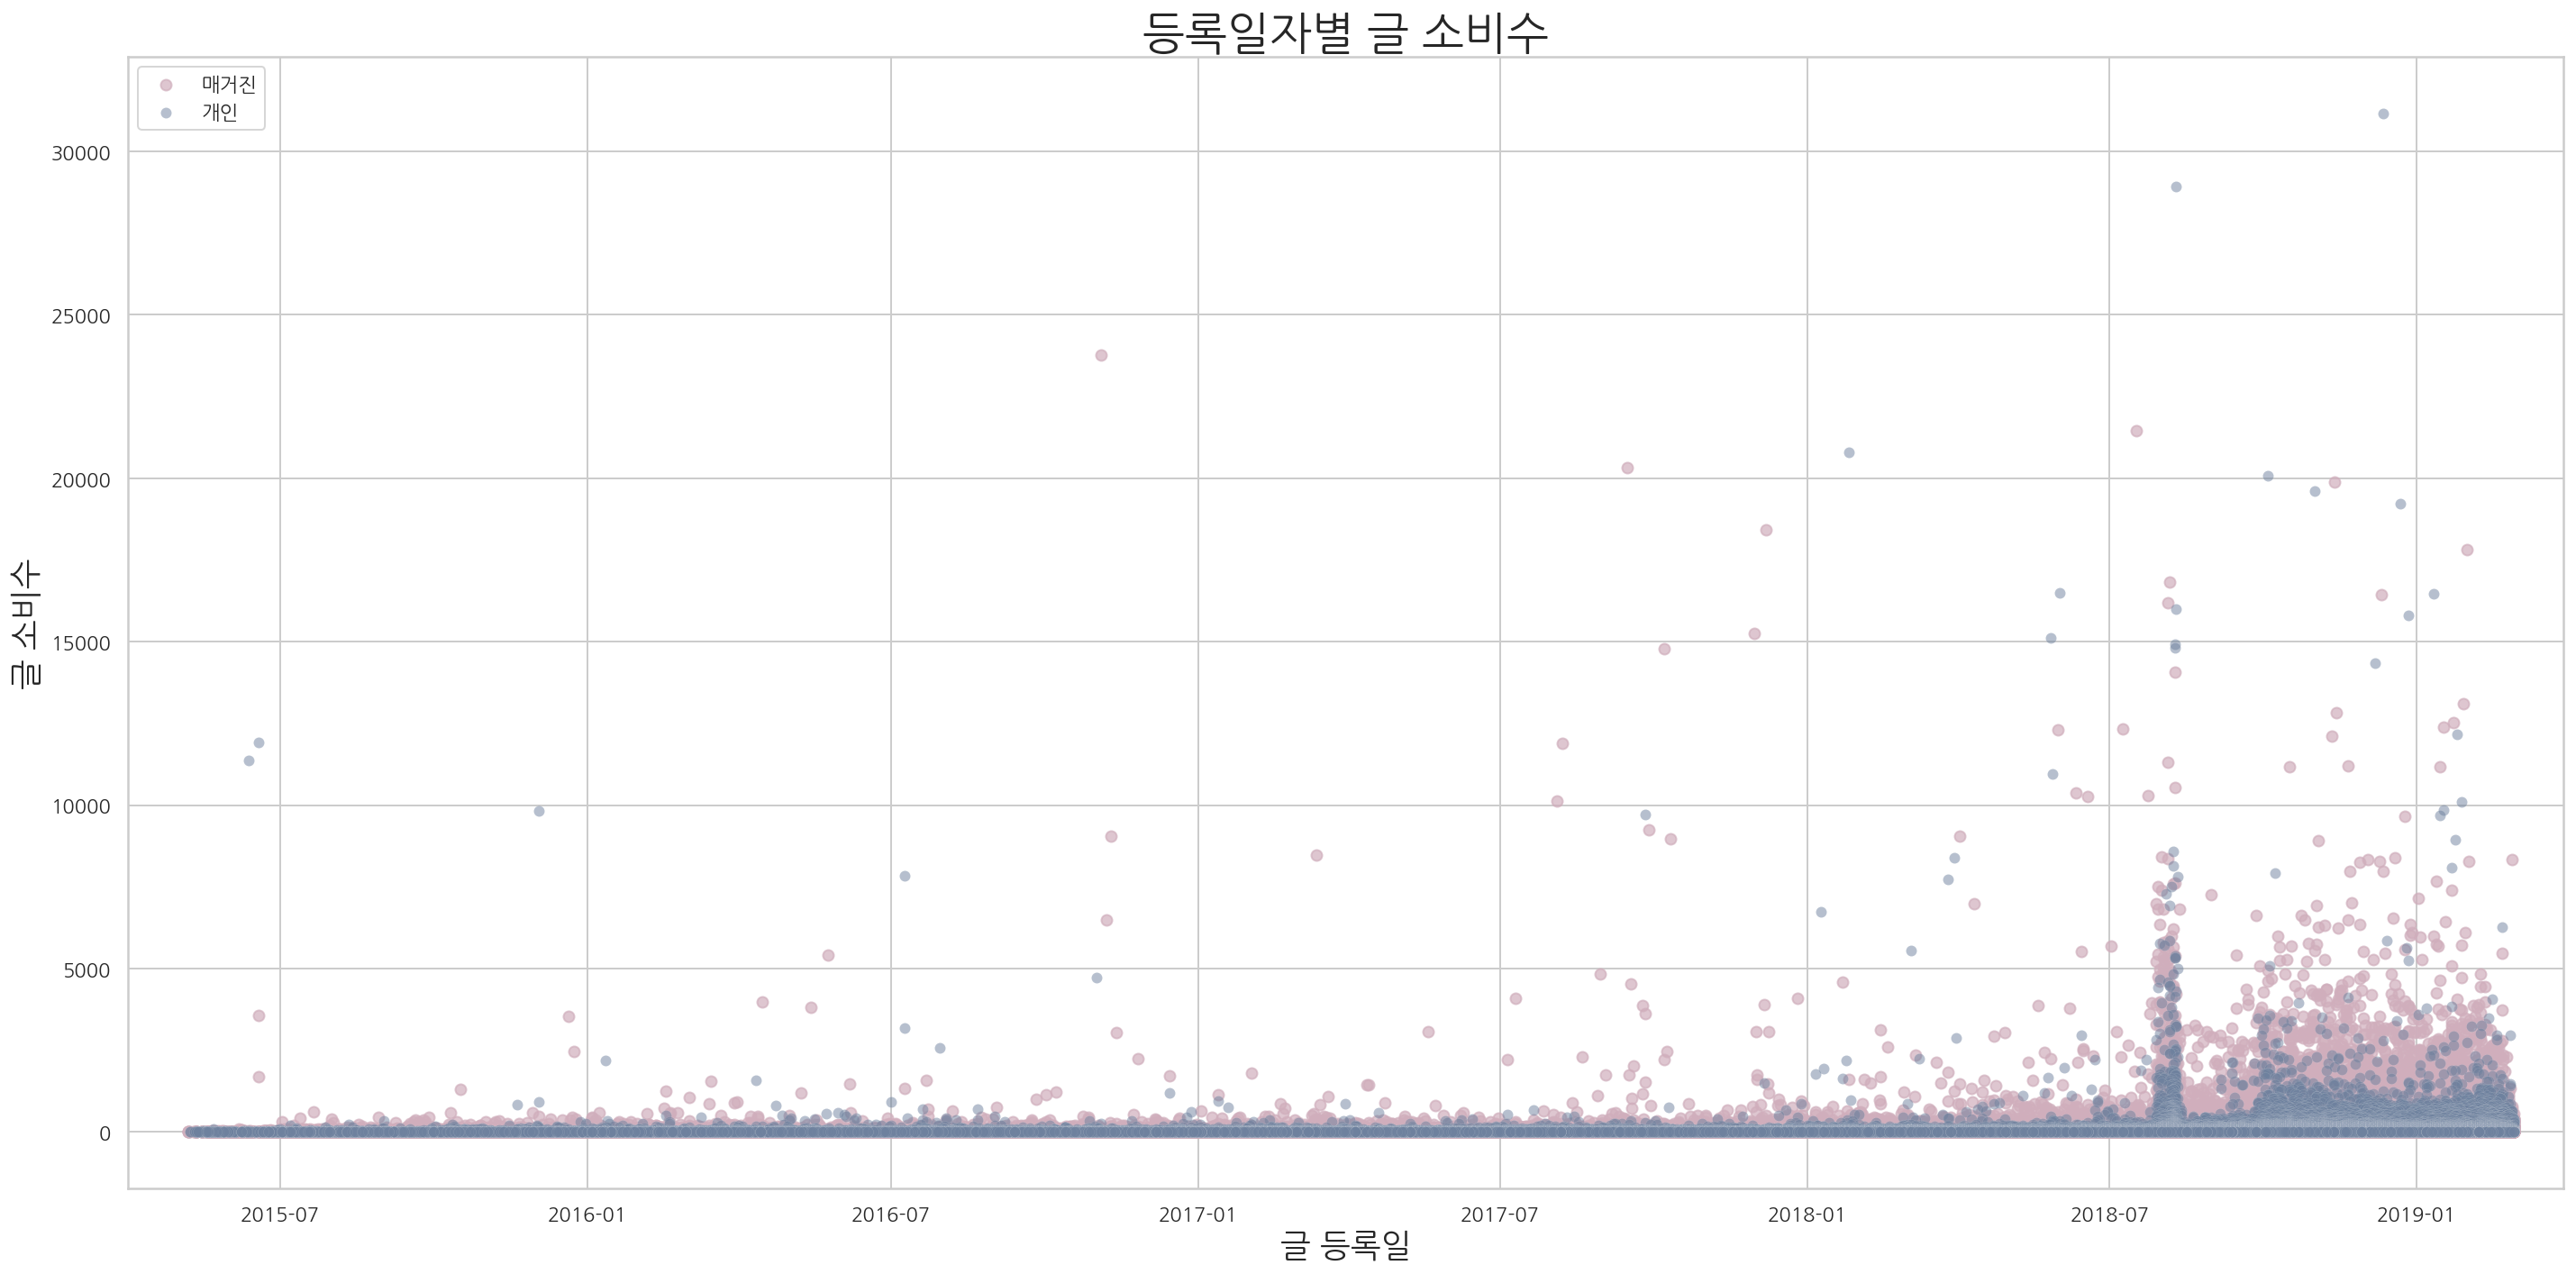

In [50]:
plt.scatter(x=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "매거진"]["reg_dt"],
            y=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "매거진"]["read_cnt"], c="#d0aebc", alpha=0.7)
plt.scatter(x=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "개인"]["reg_dt"], y=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "개인"]["read_cnt"],
            c="#6e819e", linewidth=0.08, alpha=0.5, edgecolors="w")
plt.xlim(datetime.date(datetime(2015, 4, 1)),
         datetime.date(datetime(2019, 3, 30)))
plt.title("등록일자별 글 소비수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 소비수", fontsize=18)
plt.legend(["매거진", "개인"], loc="upper left")

plt.savefig("Brunch_등록일자별_글_소비수[아웃라인제거].png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 독보적으로 글의 소비수가 많은 두개의 글을 제외하고 본 결과 등록일자가 최신일수록 글의 소비수가 많으며 매거진이 개인이 쓴 글보다 이러한 현상이 더 뚜렷히 나타남

## 3) 경과일에 따른 글 소비 변화

### a. 데이터 전처리

In [51]:
off_data = pd.merge(read, atc, how="inner",
                    left_on="article_id", right_on="article_id")

In [52]:
off_data.shape

(20905040, 15)

In [53]:
off_data.rename(columns={"dt": "read_dt"}, inplace=True)
off_data = off_data[["read_dt", "reg_dt", "readers_id", "article_id", "author_id",
                     "title", "sub_title", "type", "display_url", "keyword_list", "magazine_id"]]

In [54]:
off_data.head(3)

read_dt      reg_dt                         readers_id   article_id  \
0  20181001  2018-10-01  #e208be4ffea19b1ceb5cea2e3c4dc32c  @kty0613_91   
1  20181001  2018-10-01  #e6097910257c8b79380da50b4bce705b  @kty0613_91   
2  20181001  2018-10-01  #abfa7b43a9c3f4894ca450b0436fcd38  @kty0613_91   

  author_id          title                  sub_title type  \
0  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
1  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
2  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   

                        display_url    keyword_list  magazine_id  
0  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720  
1  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720  
2  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720

In [55]:
off_data["read_dt"] = pd.to_datetime(off_data["read_dt"], format="%Y%m%d")
off_data["reg_dt"] = pd.to_datetime(off_data["reg_dt"], format="%Y-%m-%d")
off_data["off_day"] = (off_data["read_dt"] - off_data["reg_dt"]).dt.days

In [56]:
# 글별 소비수 count DataFrame 인 atc_read_cnt_nn과 결합
off_data = pd.merge(off_data, atc_read_cnt_nn[[
                    "article_id", "read_cnt", "class"]], how="left", left_on="article_id", right_on="article_id")

In [57]:
off_data.shape

(20905040, 14)

In [58]:
off_data.head(3)

read_dt     reg_dt                         readers_id   article_id  \
0 2018-10-01 2018-10-01  #e208be4ffea19b1ceb5cea2e3c4dc32c  @kty0613_91   
1 2018-10-01 2018-10-01  #e6097910257c8b79380da50b4bce705b  @kty0613_91   
2 2018-10-01 2018-10-01  #abfa7b43a9c3f4894ca450b0436fcd38  @kty0613_91   

  author_id          title                  sub_title type  \
0  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
1  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
2  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   

                        display_url    keyword_list  magazine_id  off_day  \
0  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   
1  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   
2  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   

   read_cnt class  
0       298    5%  
1       298    5%  
2       298    5%

In [59]:
off_data_count = off_data.groupby(["article_id", "off_day", "read_dt", "reg_dt", "title", "author_id",
                                   "type", "display_url", "magazine_id", "class"], as_index=False)["readers_id"].count()

In [60]:
# 등록일자가 1970-01-01로 된 로그들 (등록일자 누락으로 추정)
off_data_count[off_data_count.reg_dt == "1970-01-01 00:00:00"].head(3)

article_id  off_day    read_dt     reg_dt title     author_id type  \
166  @01023920600_18    17870 2018-12-05 1970-01-01  김영화가  @01023920600  매거진   
167  @01023920600_18    17891 2018-12-26 1970-01-01  김영화가  @01023920600  매거진   
168  @01023920600_18    17914 2019-01-18 1970-01-01  김영화가  @01023920600  매거진   

                              display_url  magazine_id class  readers_id  
166  https://brunch.co.kr/@01023920600/18         8123   75%           2  
167  https://brunch.co.kr/@01023920600/18         8123   75%           2  
168  https://brunch.co.kr/@01023920600/18         8123   75%           1

### b. 경과일에 따른 글 소비 변화
- 2018.10.01 이후 등록된 글 기준으로 변화를 분석

In [61]:
# 경과일자별 소비수 총합
off_day_sum = off_data_count[(off_data_count["reg_dt"] >= datetime(2018, 10, 1)) & (
    off_data_count.off_day >= 0)].groupby("off_day")["readers_id"].sum()

In [62]:
# 경과일자에 등록되어있는 아티클 수
reg_dt_cnt = off_data_count[(off_data_count['reg_dt'] >= datetime(2018, 10, 1)) & (
    off_data_count.off_day >= 0)].groupby('reg_dt')['article_id'].nunique()

In [63]:
# reg_dt_cnt.cumsum()을 해서 일자가 경과함에 따라 등록된 작가 수 누적시킨다.
off_day_avg = pd.concat([off_day_sum, reg_dt_cnt.cumsum().sort_index(ascending=False).reset_index()], axis=1)

In [64]:
off_day_avg.rename(columns={"readers_id": "readers_cnt",
                            "article_id": "article_cnt"}, inplace=True)
off_day_avg

readers_cnt     reg_dt  article_cnt
0        3142049 2019-02-28       107356
1        1726882 2019-02-27       106649
2        1017862 2019-02-26       105891
3         776093 2019-02-25       105156
4         632960 2019-02-24       104308
..           ...        ...          ...
146          432 2018-10-05         3013
147          428 2018-10-04         2424
148          262 2018-10-03         1762
149          154 2018-10-02         1239
150           67 2018-10-01          648

[151 rows x 3 columns]

- 2019-02-28 글 등록하고 경과일 0일 됐을 때 까지 소비수(readesr_id) 3142049명
- 2018-10-01 글 등록하고 경과일 150일 됐을 때(2019-02-28까지) 까지 소비수 (readers_id) 67명 

In [65]:
# 경과일에 따른 글 소비 변화 평균
off_day_avg["off_avg"] = off_day_avg["readers_cnt"] / off_day_avg["article_cnt"]

In [66]:
off_day_avg.head(10)

readers_cnt     reg_dt  article_cnt    off_avg
0      3142049 2019-02-28       107356  29.267568
1      1726882 2019-02-27       106649  16.192201
2      1017862 2019-02-26       105891   9.612356
3       776093 2019-02-25       105156   7.380397
4       632960 2019-02-24       104308   6.068183
5       529081 2019-02-23       103611   5.106417
6       436611 2019-02-22       103019   4.238160
7       412530 2019-02-21       102167   4.037801
8       236772 2019-02-20       101343   2.336343
9       193039 2019-02-19       100511   1.920576

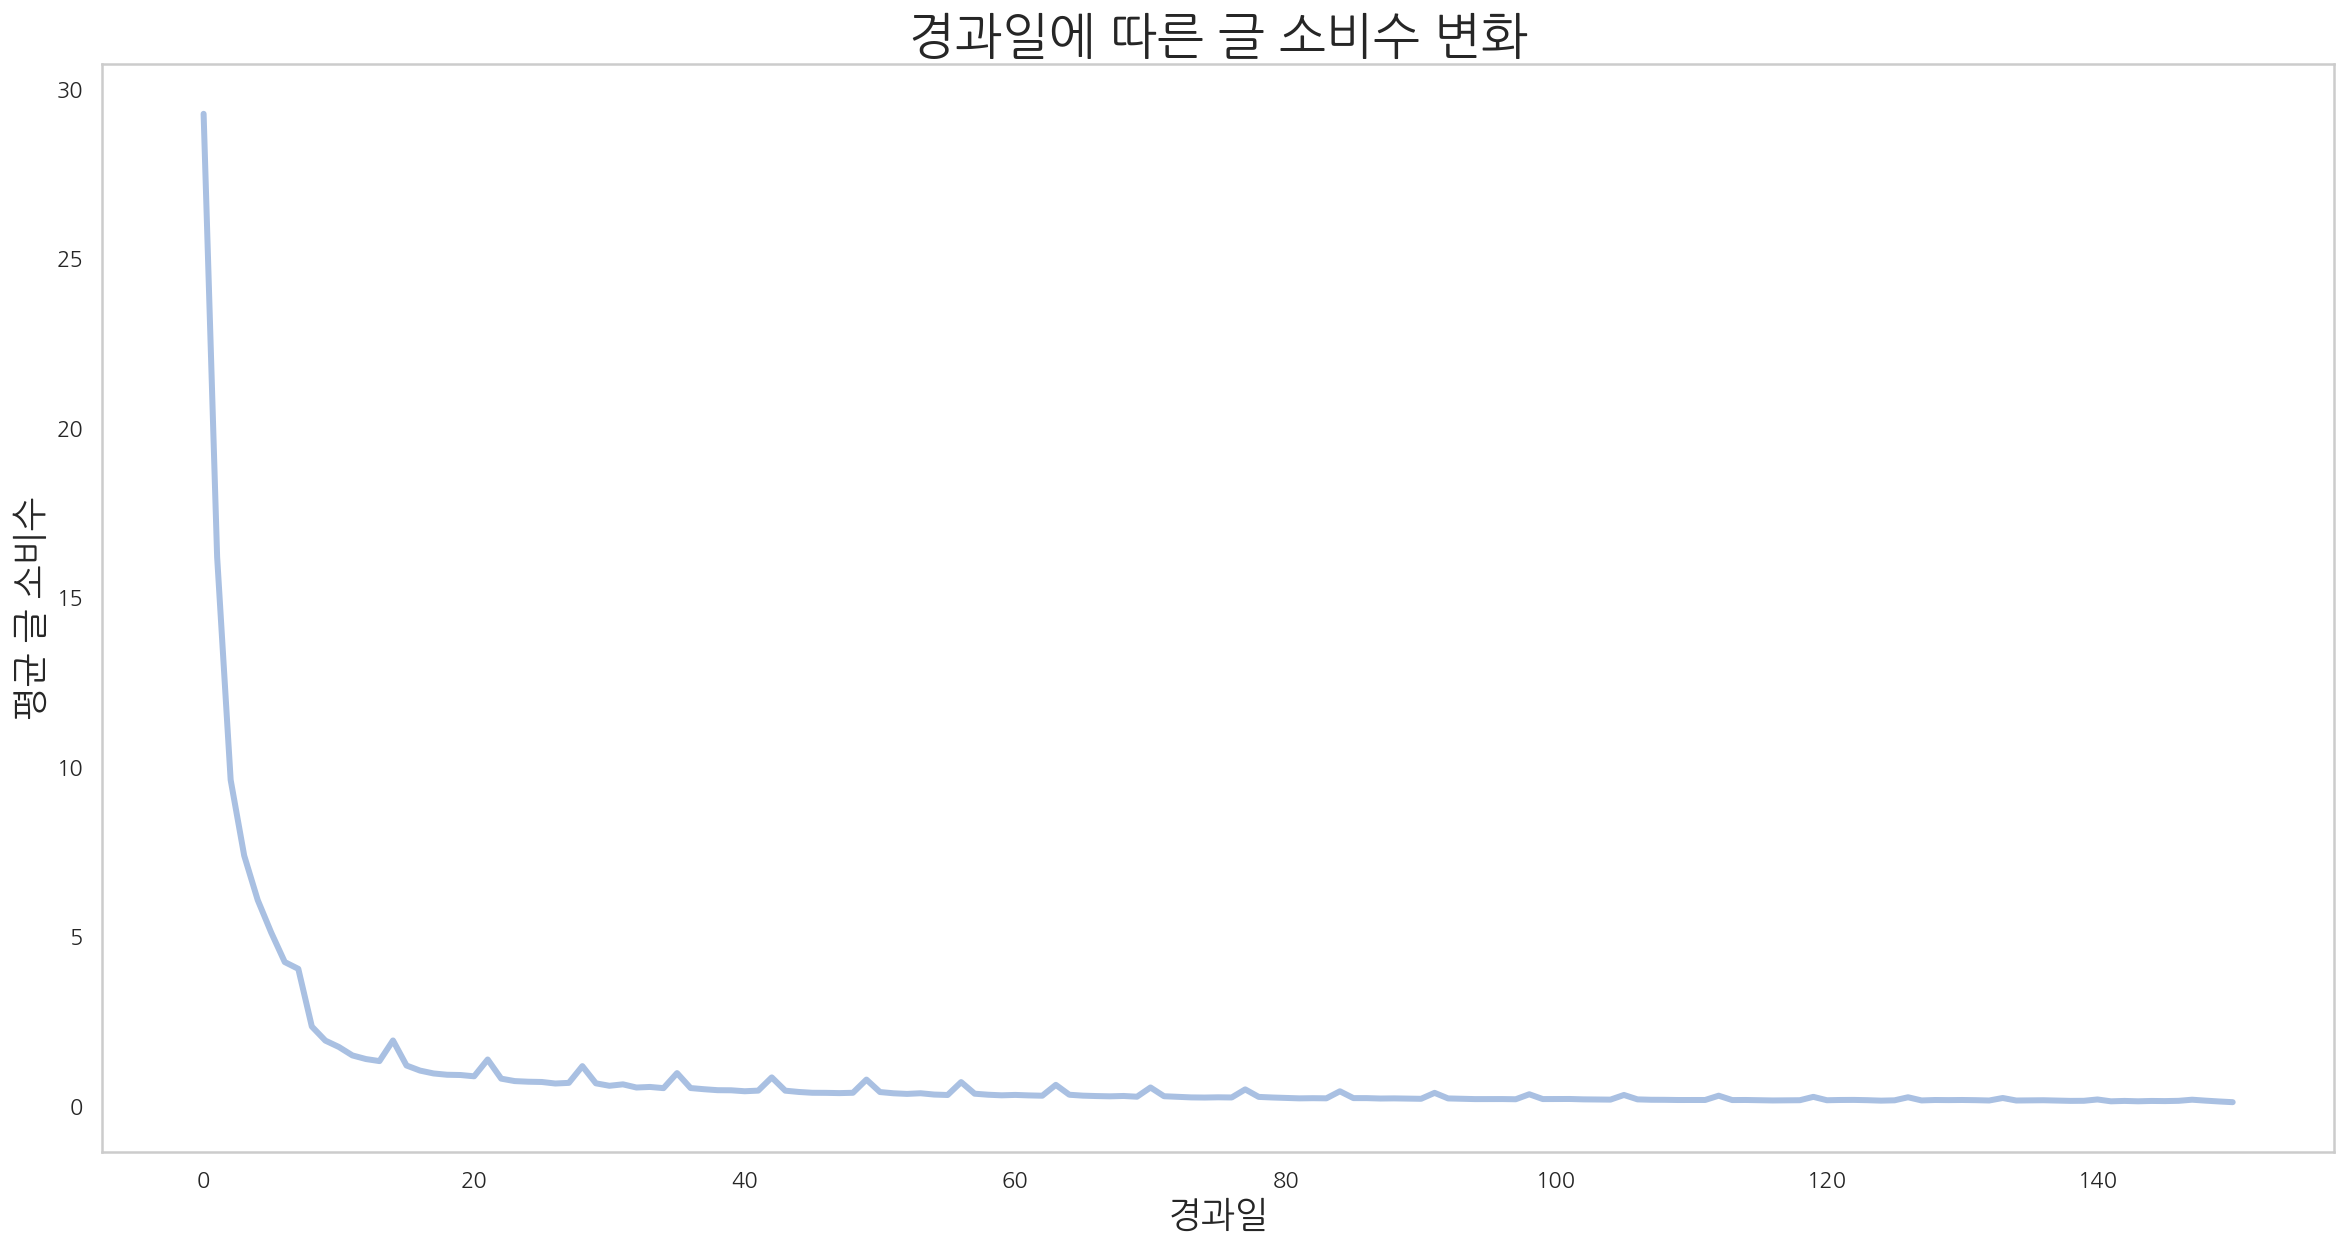

In [67]:
plt.plot(off_day_avg.index,
         off_day_avg["off_avg"], color="#a9c0e2", linestyle="-", linewidth=3.0)
plt.title("경과일에 따른 글 소비수 변화", fontsize=25)
plt.xlabel("경과일", fontsize=18)
plt.ylabel("평균 글 소비수", fontsize=18)
plt.grid(False)

plt.savefig("경과일에 따른 글 소비수 변화.png", bbox_inches="tight")
plt.show()

- 글의 등록일이 경과할 수록 글 소비수는 줄어들음. 즉, 글 등록시 소비량이 가장 많다.

## 4) 유저

In [68]:
# 유저별 방문일수, 글 소비수
grp_by_user = off_data.groupby("readers_id").agg({"read_dt": ["nunique", "count"]}).reset_index()
grp_by_user.columns = ["readers_id", "visit_day_cnt", "read_cnt"]

In [69]:
grp_by_user.head()

readers_id  visit_day_cnt  read_cnt
0  #00001ba6ca8d87d2fc34d626ba9cfe6f              1         3
1  #0000e87158c1426d6ffb72cebac6cb64              1         2
2  #0000eea6d339abfd02ed590bc451fc63              1         1
3  #0000fdba8f35c76eacab74c5c6bc7f1a              3        11
4  #000127ad0f1981cae1292efdb228f0e9              1        27

### a. 방문일수 기준 유저 통계

In [70]:
grp_by_user["visit_day_cnt"].value_counts(normalize=True)

1      0.352137
2      0.142516
3      0.088841
4      0.063050
5      0.047217
         ...   
134    0.000033
143    0.000030
145    0.000026
149    0.000023
150    0.000020
Name: visit_day_cnt, Length: 151, dtype: float64

In [71]:
grp_by_user["visit_day_cnt"].value_counts(normalize=True).sort_index()[74:].sum()

0.009034902176890052

- 1~2회 방문 유저 전체 유저중 50%
- 75회 이상 방문하는유저 전체 유저중 약 1%
- 1~2일 방문유저를 신규유저 / 75일(Train 기간 절반 방문) 방문 유저를 단골유저로 구분

In [72]:
low_visit_user = grp_by_user.loc[grp_by_user["visit_day_cnt"] <= 2, "readers_id"]

In [73]:
upp_visit_user = grp_by_user.loc[grp_by_user["visit_day_cnt"] >= 75, "readers_id"]

In [74]:
off_data_low = off_data[off_data.readers_id.isin(low_visit_user)]
off_data_upp = off_data[off_data.readers_id.isin(upp_visit_user)]

In [75]:
off_data.shape, off_data_low.shape, off_data_upp.shape

((20905040, 14), (1083925, 14), (5002114, 14))

In [76]:
1083925/20905040*100, 5002114/20905040*100

(5.18499366659906, 23.92778966220586)

- 신규 유저의 글 소비는 전체의 5%, 단골 유저의 글 소비는 전체의 24%

In [77]:
off_data_low.groupby("readers_id")["article_id"].count().mean(), off_data_low.groupby("readers_id")["article_id"].count().std()

(7.230842611555473, 13.573547204837958)

In [78]:
off_data_upp.groupby("readers_id")["article_id"].count().mean(), off_data_upp.groupby("readers_id")["article_id"].count().std()

(1826.9225712198686, 2758.1071094196964)

- 신규 유저의 평균 글 소비수는 7, 표준편차 14
- 단골 유저의 평균 글 소비수는 1827, 표준편차 2758

### b. 신규/단골 그룹내 인기 글

In [79]:
off_data_low.head(3)

read_dt     reg_dt                         readers_id   article_id  \
15 2018-10-01 2018-10-01  #31a8a8fc92ca562482304fddfec6bd1f  @kty0613_91   
20 2018-10-01 2018-10-01  #10c4d5c9fbaf041d8cca5b6dcfe9cc0c  @kty0613_91   
41 2018-10-01 2018-10-01  #097a38fffed0eb0012a705d4902df95b  @kty0613_91   

   author_id          title                  sub_title type  \
15  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
20  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   
41  @kty0613  좋은 이성을 만나는 기준  문제는 만남의 '기회'가 아닌 만남의 '기준'  매거진   

                         display_url    keyword_list  magazine_id  off_day  \
15  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   
20  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   
41  https://brunch.co.kr/@kty0613/91  [연애, 남자친구, 이성]        38720        0   

    read_cnt class  
15       298    5%  
20       298    5%  
41       298    5%

In [80]:
off_data_low_rk = off_data_low.groupby(["article_id", "title", "reg_dt"])["readers_id"].count().sort_values(ascending=False)
off_data_low_rk = off_data_low_rk.reset_index()
off_data_low_rk["rank"] = off_data_low_rk.index + 1

In [81]:
off_data_upp_rk = off_data_upp.groupby(["article_id", "title", "reg_dt"])["readers_id"].count().sort_values(ascending=False)
off_data_upp_rk = off_data_upp_rk.reset_index()
off_data_upp_rk["rank"] = off_data_upp_rk.index + 1

In [82]:
# 신규 독자 소비수 상위 상위 10개 글
off_data_low_rk.head(10)

article_id                           title     reg_dt  readers_id  \
0        @brunch_141      브런치 작가가 함께 빨강머리 앤을 그리고 쓰다. 2018-10-17       13519   
1        @brunch_151      브런치 무비 패스, 영화의 진한 여운을 나누세요 2019-02-18        8160   
2          @brunch_1               글이 작품이 되는 공간, 브런치 2015-06-12        5282   
3        @brunch_140  카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다. 2018-10-04        4343   
4          @brunch_2                    브런치 작가 신청 안내 2015-06-18        4068   
5        @brunch_145   10인의 에디터와 함께 하는, 브런치북 프로젝트 #6 2018-12-12        2897   
6        @brunch_133         또 다른 기회의 시작, 브런치와 함께하세요 2018-07-09        2640   
7  @kakaomobility_20                       음성으로 편리하게 2018-10-17        2458   
8    @intlovesong_28                  아끼면 똥 되는 것 4가지 2016-11-04        2226   
9        @brunch_142               [예고] 브런치북 프로젝트 #6 2018-11-01        2221   

   rank  
0     1  
1     2  
2     3  
3     4  
4     5  
5     6  
6     7  
7     8  
8     9  
9    10

In [83]:
# 단골 독자 소비수 상위 상위 10개 글
off_data_upp_rk.head(10)

article_id                          title     reg_dt  readers_id  rank
0      @brunch_141     브런치 작가가 함께 빨강머리 앤을 그리고 쓰다. 2018-10-17       11636     1
1      @brunch_151     브런치 무비 패스, 영화의 진한 여운을 나누세요 2019-02-18        6010     2
2      @brunch_145  10인의 에디터와 함께 하는, 브런치북 프로젝트 #6 2018-12-12        4379     3
3    @tenbody_1305  러닝머신보다 효과 좋은 체지방 빼는 맨몸 운동 5가지 2018-08-10        3674     4
4    @hyehyodam_19                나쁜년이 잘 사는 이유... 2018-01-26        2920     5
5  @sangheeshyn_66                     살찌지 않는 여자들 2018-11-13        2866     6
6      @brunch_142              [예고] 브런치북 프로젝트 #6 2018-11-01        2753     7
7  @intlovesong_28                 아끼면 똥 되는 것 4가지 2016-11-04        2606     8
8         @x-xv_19           승무원, 들어오려는 자, 나가려는 자 2018-08-05        2603     9
9      @steven_179               친구 없는 사람의 3가지 특징 2017-09-15        2597    10

- 신규 유저는 기본 brunch 매거진 글을 많이 보는 경향이 있음
- 신규와 단골 비슷한 경향이 나오지만 단골이 신규보단 더 다양한 작가의 글을 읽음

## 5) Following List

### a. Following List 통계

In [84]:
# following_list가 있는 유저
following = users[users["author_id"].str.len() != 0]

In [85]:
following.shape[0] / users.shape[0]

0.9766120260781701

- 98%의 유저가 follow하는 작가가 있음

In [86]:
# author_id 리스트 안에 author_id 갯수 확인
following["author_cnt"] = users["author_id"].str.len()

In [87]:
# 평균 following하는 작가 수
following["author_cnt"].mean()

8.622620185179084

- follow하고 있는 유저는 평균 9명의 작가를 구독 중

In [88]:
following["author_id"] = following["author_id"].apply(lambda x: " ".join(x))

In [89]:
following.head()

search_keyword_list                                          author_id  \
0                  []                                  @perytail @brunch   
1                  []  @holidaymemories @wadiz @sciforus @dailydubu @...   
2                  []  @commerceguy @sunsutu @kakao-it @joohoonjake @...   
3                  []  @amberjeon48 @forsy20 @nemotokki @hawann @bpmb...   
4                  []  @dwcha7342 @iammento @kakao-it @dkam @anti-ess...   

                          readers_id  author_cnt  
0  #901985d8bc4c481805c4a4f911814c4a           2  
1  #1fd89e9dcfa64b45020d9eaca54e0eed          75  
2  #1d94baaea71a831e1f33e1c6bd126ed5           5  
3  #04641c01892b12dc018b1410e4928c0d          84  
4  #65bcaff862aadff877e461f54187ab62          19

In [90]:
following_lens = following["author_id"].str.split(" ").map(len)

In [91]:
following_df = pd.DataFrame({"readers_id": np.repeat(following["readers_id"], following_lens),
                             "author_id": list(chain.from_iterable(following["author_id"].str.split(" ")))})

In [92]:
# 가장 구독하는 유저가 많은 작가 리스트
following_df["author_id"].value_counts(ascending=False)[:20]

@brunch         292413
@dryjshin         9011
@tenbody          8615
@roysday          8500
@yumileewyky      6116
@varo             5688
@yoonash          5653
@imagineer        5483
@lunarshore       5414
@ebprux           5374
@haneulalice      5341
@suhanjang        4911
@daljasee         4756
@mobiinside       4743
@sustainlife      4655
@bang1999         4577
@seochogirl       4441
@annejeong        4426
@eastgo           4387
@hyejinchoi       4305
Name: author_id, dtype: int64

In [93]:
following_read = pd.merge(off_data, following_df, how="inner", left_on=["readers_id", "author_id"], right_on=["readers_id", "author_id"])

In [94]:
following_read.shape[0] / off_data.shape[0]

0.3485478621423351

- 전체 소비 데이터중 구독하고 있는 작가의 글 소비 비중이 35%

## 6) Readers별 article 건수 분석
- 월별 Readers_article 건수(brunch 글 읽은 건수) 분포 분석

In [61]:
r_df = read.copy()

In [44]:
r_df.head(3)

dt  hr                         readers_id      article_id
0  20181001  00  #e208be4ffea19b1ceb5cea2e3c4dc32c     @kty0613_91
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c  @miamiyoung_31
1  20181001  00  #0a3d493f3b2318be80f391eaa00bfd1c   @banksalad_49

In [63]:
r_df["dt"] = r_df["dt"].apply(pd.to_datetime)
r_df.set_index('dt', drop=True, inplace=True)

In [64]:
r_df.to_csv("r_df.csv", index=False)

In [46]:
## 월별 읽은 건수 counting
month_read_distribution = r_df.resample('M').count()

In [48]:
month_read_distribution["read_count"] = r_df.resample('M')['readers_id'].nunique()
month_read_distribution["read_mean"] = month_read_distribution.readers_id / r_df.resample('M')['readers_id'].nunique()
month_read_distribution.drop(columns=["hr", "readers_id"], inplace=True)

In [52]:
# 월별 읽은 건수 평균
month_read_distribution.head()

article_id  read_count  read_mean
dt                                           
2018-10-31     4306658      117829  36.550068
2018-11-30     4013656      109266  36.732890
2018-12-31     4047555      114962  35.207764
2019-01-31     4839425      120986  39.999876
2019-02-28     4903412      118091  41.522318

In [53]:
month_read_distribution.read_mean.mean()

38.00258331103539

- 월별 읽은 평균 건수의 5개월간 평균은 38건이다.

In [65]:
## 월별 읽은 건수 describe
r_10 = r_df[r_df.index.month==10].groupby("readers_id").count().describe()
r_11 = r_df[r_df.index.month==11].groupby("readers_id").count().describe()
r_12 = r_df[r_df.index.month==12].groupby("readers_id").count().describe()
r_1 = r_df[r_df.index.month==1].groupby("readers_id").count().describe()
r_2 = r_df[r_df.index.month==2].groupby("readers_id").count().describe()

In [66]:
# 월별 읽은 건수 describe 총 평균
round(pd.concat([r_10, r_11, r_12, r_1, r_2], axis=1).mean(axis=1))

count    116227.0
mean         38.0
std         151.0
min           1.0
25%           2.0
50%           8.0
75%          27.0
max       21059.0
dtype: float64

In [67]:
# 월별 읽은 건수 describe 총 평균의 Upper Fence 확인
(27-2)*1.5 + 27

64.5

- min : 1건
- 25% : 2건
- 50% : 8건 
- 75% : 27건 
- upper fence : 64.5건 (내림 64건)


=> 하나도 읽지 않음 : 0건 <br>
=> min-50% : 1건-8건 (1건 / 2-8건)<br>
=> 50%-upper fence : 9건-64건 (9-27건 / 28-64건)<br>
=> upper-fence-max : 65건-21059건<br>

# 3. Train기간 뽑기
- 위의 EDA 결과를 바탕으로 등록된 글 최신으로 train_data를 뽑는다.
- 기간 : 2019.02.15-2019.03.01

In [3]:
meta_df = metadata.copy()

In [ ]:
metadata.rename(columns={"user_id": "author_id",
                         "article_id": "article_number", "id": "article_id"}, inplace=True)

In [4]:
meta_df.drop(columns="article_number", inplace=True)

In [34]:
meta_df["reg_datetime"] = meta_df["reg_ts"].apply(lambda x: datetime.fromtimestamp(x/1000.0))
meta_df["reg_dt"] = meta_df["reg_datetime"].dt.date
meta_df.drop(columns=["display_url", "sub_title", "title", "magazine_id"], inplace=True)

In [35]:
meta_df.head(2)

author_id     keyword_list         reg_ts     article_id  \
0     @bookdb   [여행, 호주, 국립공원]  1474944427000    @bookdb_782   
1  @kohwang56  [목련꽃, 아지랑이, 동행]  1463092749000  @kohwang56_81   

         reg_datetime      reg_dt  
0 2016-09-27 11:47:07  2016-09-27  
1 2016-05-13 07:39:09  2016-05-13

In [36]:
meta_train = meta_df[(meta_df.reg_datetime >= datetime(2019, 2, 15))&(meta_df.reg_datetime <= datetime(2019, 3, 31))]

In [37]:
meta_df.shape, meta_train.shape

((643104, 6), (34054, 6))

In [38]:
train = pd.merge(left=meta_train, right=read, left_on="article_id", right_on="article_id", how="left")

In [39]:
train.shape, train[train.isnull().values].shape, train.shape[0]-train[train.isnull().values].shape[0]

((980469, 9), (70554, 9), 909915)

- Train 기간동안 글의 정보만 있는 경우 (read 읽은 정보가 없어서 nan값) : 70554 건
- Train 기간동안 읽은 글의 정보는 : 909915건

In [41]:
train.drop(columns=["reg_ts", "reg_datetime"], inplace=True)
train.rename(columns={"dt":"read_dt", "hr":"read_hr"}, inplace=True)

In [86]:
train

author_id         keyword_list            article_id  \
0                 @hukho        [패션, 에세이, 경제]            @hukho_247   
1          @haninorway19         [엄마, 취향, 효도]     @haninorway19_103   
2                 @jerad       [팀워크, 성과, 개인기]            @jerad_200   
3            @sharppen01       [취업, 사회생활, 결혼]        @sharppen01_25   
4           @swkyung0221  [젠트리피케이션, 주거문화, 서울]        @swkyung0221_3   
...                  ...                  ...                   ...   
980464  @riglobalization  [포틀랜드, 라이프스타일, 자영업]  @riglobalization_132   
980465  @riglobalization  [포틀랜드, 라이프스타일, 자영업]  @riglobalization_132   
980466  @riglobalization  [포틀랜드, 라이프스타일, 자영업]  @riglobalization_132   
980467      @yumileewyky       [스타트업, 생각, 공간]      @yumileewyky_314   
980468           @uxstar        [3D, UI, 제스처]            @uxstar_24   

            reg_dt   read_dt read_hr                         readers_id  
0       2019-03-06       NaN     NaN                                NaN  
1       2019-03-22       NaN     NaN                                NaN  
2       2019-03-01       NaN     NaN                                NaN  
3       2019-03-18       NaN     NaN                                NaN  
4       2019-03-09       NaN     NaN                                NaN  
...            ...       ...     ...                                ...  
980464  2019-02-28  20190228      22  #eb38665bedba63602d2df33e85ffd40e  
980465  2019-02-28  20190228      22  #eb38665bedba63602d2df33e85ffd40e  
980466  2019-02-28  20190228      23  #420bb7a23c40541c1aee49352b1be859  
980467  2019-03-11       NaN     NaN                                NaN  
980468  2019-03-25       NaN     NaN                                NaN  

[980469 rows x 7 columns]

# Module 만들기
- Data 전처리
- Train Data 생성
- upper fence 아웃라인 제거 Data
- 모델링에 필요한 여러 Data 생성
    - Train 기간동안의 등록된 글을 읽은 건수 별 Data
    - readers별 article_list, article_count Data에 magazine, users Data를 merge한 Data

In [53]:
%%writefile Brunch_data.py

# import
import numpy as np
import pandas as pd
import os
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import warnings
warnings.filterwarnings('ignore')


# 1. Data 기본 전처리 및 [2019.02.15-2019.03.31]최신 기간 등록된 글로 Train 및 추천
class Data():
    def __init__(self, meta, read_file_list, magazine, users):
        self.meta = meta
        self.read_list = read_file_list
        self.magazine = magazine
        self.users = users
        
    def data_preprocessing(self, dev):
        self.meta.drop(columns="article_id", inplace=True)
        self.meta.rename(columns={"user_id": "author_id", "id": "article_id"}, inplace=True)
        self.magazine.rename(columns={"id": "magazine_id"}, inplace=True)
        self.users.rename(columns={"id": "readers_id", "keyword_list": "search_keyword_list"}, inplace=True)
        self.users = self.users[~self.users.readers_id.isin(list(dev.readers_id))]
        self.meta["type"] = self.meta["magazine_id"].apply(lambda x: "개인" if x == 0.0 else "매거진")

        read_df_lst = []
        for file in self.read_list:
            file_name = os.path.basename(file)
            file_df = pd.read_csv(file, header=None, names=["raw"])
            file_df["dt"] = file_name[:8]
            file_df["hr"] = file_name[8:10]
            file_df["readers_id"] = file_df["raw"].str.split(" ").str[0]
            file_df["article_id"] = file_df["raw"].str.split(" ").str[1:].str.join(" ").str.strip()
            read_df_lst.append(file_df)
        read_df = pd.concat(read_df_lst)
        read_count = read_df["article_id"].str.split(" ").map(len)
        self.read = pd.DataFrame({"dt": np.repeat(read_df["dt"], read_count),
                             "hr": np.repeat(read_df["hr"], read_count),
                             "readers_id": np.repeat(read_df["readers_id"], read_count),
                             "article_id": list(chain.from_iterable(read_df["article_id"].str.split(" ")))})
        
        del read_df, read_count
        
        return self.meta, self.read, self.magazine, self.users
    
    ## dev에 맞춰 Test데이터 뽑기
    def test_data(self, dev):
        self.test_data = pd.merge(left=self.meta, right=self.read[self.read.readers_id.isin(list(dev.readers_id))], 
                             left_on="article_id", right_on="article_id", how="right")
        self.read = self.read[~self.read.readers_id.isin(list(dev.readers_id))]
        return self.test_data
    
    ## 최신 기간에 등록된 글로만 추천 [2019.02.15-2019.03.31] (Train_data 만들기)
    def train_data(self):        
        self.meta["reg_datetime"] = self.meta["reg_ts"].apply(lambda x: datetime.fromtimestamp(x/1000.0))
        self.meta["reg_dt"] = self.meta["reg_datetime"].dt.date
        self.meta.drop(columns=["display_url", "sub_title", "title"], inplace=True)

        metadata_train = self.meta[(self.meta.reg_datetime >= datetime(2019, 2, 15))&(self.meta.reg_datetime <= datetime(2019, 3, 31))]
        
        self.train = pd.merge(left=metadata_train, right=self.read, left_on="article_id", right_on="article_id", how="inner")

        self.train.drop(columns=["reg_ts", "reg_datetime"], inplace=True)
        self.train.rename(columns={"dt":"read_dt", "hr":"read_hr"}, inplace=True)
        
        del metadata_train

        return self.train
    
    ## train data에 article_id별 keyword_list 뽑기
    def train_keyword_list(self):
        self.keyowrd_list = self.train[['article_id', 'keyword_list']]
        self.keyowrd_list.drop_duplicates('article_id', ignore_index=True, inplace=True)
        
        return self.keyowrd_list

    
# 2. Train data에서 readers별 읽은 article 건수 및 list DataFrame 생성 및 upper_fense 이상치 제거
class Read_article_outline_remove():
    def __init__(self, train):
        self.train = train
    
    ## readers_id 별 article_id 건수 및 list Dataframe 생성
    def read_article_list(self):
        self.train.article_id = self.train.article_id+" "

        self.readers_article_list = self.train.groupby("readers_id")["article_id"].sum().reset_index()
        self.readers_article_list["article"] = self.readers_article_list.article_id.apply(lambda x: x.split(" "))
        self.readers_article_list["article"] = self.readers_article_list.article.apply(lambda x: x[:-1])

        ### readers_id 별 리스트 안의 article_id의 중복 제거해주기
        self.readers_article_list["article_list"]=self.readers_article_list.article.apply(lambda x: list(set(x)))
        self.readers_article_list.drop(columns=["article", "article_id"], inplace=True)

        self.readers_article_list["article_id_count"]=self.readers_article_list.article_list.apply(lambda x: len(x))

        return self.readers_article_list

    ## upper_fence기준 이상치 제거
    def upper_fence_remove(self):
        iqr = np.percentile(self.readers_article_list["article_id_count"], 75) - np.percentile(self.readers_article_list["article_id_count"], 25)
        self.upper_fence_df = self.readers_article_list[self.readers_article_list.article_id_count < 11+iqr*1.5]

        return self.upper_fence_df
        
    
# 3. readers_article_list 건수별 나누기 [1: 1건, 2: 2-4건, 3: 5-11건, 4: 12-25건]
def ra_article_count_division_1(data):
    """
    function : Divide ra(up) dataframe by 1 read
    input : readers_article_list Dataframe,  upper_fence Dataframe
    output : division dataframe (article count == 1)
    """
    return data[data["article_id_count"] == 1]

def ra_article_count_division_2(data):
    """
    function : Divide ra(up) dataframe into 2 to 8 reads
    input : readers_article_list Dataframe,  upper_fence Dataframe
    output : division dataframe (article count == 2-8)
    """    
    return data[(data["article_id_count"] >= 2) & (data["article_id_count"] <= 8)]

def ra_article_count_division_3(data):
    """
    function : Divide ra(up) dataframe into 9 to 27 reads
    input : readers_article_list Dataframe,  upper_fence Dataframe
    output : division dataframe (article count == 9-27)
    """    
    return data[(data["article_id_count"] >= 9) & (data["article_id_count"] <= 27)]

def ra_article_count_division_4(data):
    """
    function : Divide ra(up) dataframe into 28 to 64 reads    
    input : readers_article_list Dataframe,  upper_fence Dataframe
    output : division dataframe (article count == 28-64)
    """    
    return data[(data["article_id_count"] >= 28) & (data["article_id_count"] <= 64)]

#4. train들어올때 건수별 나누기 만들기
def train_article_count_division(input_data, start_count, stop_count, output_data):
    """
    function : division train dataframe by number of read
    input : train Dataframe, target Dataframe
    output : division train
    arguments : input_data, start_count, stop_count, output_data
    
    - min : 1
    - 25% : 2
    - 50% : 8 
    - 75% : 27 
    - upper fence : 64.5 (round down : 64)

    => unread : 0
    => min-50% : 1-8 (1 / 2-8)
    => 50%-upper fence : 9-64 (9-27 / 28-64)
    => upper-fence-max : 65-21059
    """
    read_count = input_data.groupby('readers_id').count().article_id
    group = output_data[output_data["readers_id"].isin(read_count[(read_count >= start_count)&(read_count <= stop_count)].index)]    
    return group

# 5. readers_article_list Data와 다른 Data의 merge를 통한 새로운 DataFrame 생성
class New_data():
    def __init__(self, data):
        self.data = data
        
    ## readers_article_list와 article별 magazine_id 데이터 생성
    def ra_magazine_df(self, read, meta, maga):
        self.read = read
        self.meta = meta
        self.maga = maga
        
        df1 = pd.merge(left=self.read, right=self.meta, left_on="article_id", right_on="article_id", how="inner")
        df2 = pd.merge(left=self.data, right=df1, left_on="readers_id", right_on="readers_id", how="left")
        self.df3 = pd.merge(left=df2, right=self.maga, left_on="magazine_id", right_on="magazine_id", how="left")
        self.df3 = self.df3.drop_duplicates(["readers_id", "article_id", "reg_datetime"])
        
        del df1, df2
        
        return self.df3
        
    ## readers_article_list와 readers별 searching_keyword, Following_list 데이터 생성
    def ra_searching_following_df(self, users):
        self.users = users
        self.df4 = pd.merge(left=self.data, right=self.users, left_on="readers_id", right_on="readers_id", how="left")
        return self.df4

    ## readers_article_list와 article별 magazine_id, readers별 searching_keyword, Following_list 데이터 생성
    def ra_total_df(self):
        df5 = pd.merge(left=self.df3, right=self.df4, left_on="readers_id", right_on="readers_id", how="inner")
        df5.rename(columns={"article_list_x":"article_list", "article_id_count_x":"article_id_count"}, inplace=True)
        df5.drop(columns=["reg_ts", "article_list_y", "article_id_count_y"], inplace=True)
        df5 = df5.drop_duplicates(["readers_id", "article_id", "reg_datetime"])
        
        return df5
    
# 6. 인기글 추천해주는 Data 
def popular_weight_data(train):
    popular = train.groupby("article_id").nunique().readers_id.sort_values(ascending=False)
    for i in popular.index:
        train.loc[train["article_id"]== i,"popular_weight"] = popular[i]
    return train

Overwriting Brunch_data.py
